# **Analyse de sentiments sur les films du TOP 100 box office (Notebook principal)**
**Projet Python - 2A ENSAE**

AUMONT Louis-Armand, KHAIRALDIN Ahmed, GIMENES Vincent

## Introduction

L'objectif de ce Notebook va être de: 
+ **1)** charger la base de données, puis nettoyer les commentaires pour les "tokenisés" et enfin les "lemmatisés"
+ **2)** appliquer des algorithmes de NLP sur nos commentaires "lemmatisés" afin de déduire pour chaque commentaire un score de polarité
+ **3)** Procéder à une analyse de statistique descriptive avec nos variables et visualiser des relations entre elles
+ **4)** Modéliser pour tenter d'analyser les relations entre nos variables (linéaires, quadratiques), si pas de relation apparente, tester statistiquement la non-corrélation


### Traitement des données et analyse de sentiments

Avant de pouvoir faire de l'analyse de sentiment pour chaque commentaire, il faut d'abord les nettoyer pour les rendre lisibles pour l'ordinateur. Premièrement, nous allons transformer le fichier data_reviews en une base de données où chaque observation est un commentaire. Puis, nous allons nettoyer chaque commentaire en utilisant des fonctions permettant de supprimer la ponctuation, les stop-words et la lemmatisation.



####  Download Library ⚙️

In [3]:
#pip install spacy
#!pip install wordcloud
#!pip install textblob

####  Import Library 📦

In [2]:
# Importation de packages nécessaires

import pandas as pd
import json
import nltk
import spacy
import matplotlib.pyplot as plt


from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

In [3]:
# Téléchargement d'éléments nécessaires à la tokenisation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## **1.** Création de la base de données des commentaires

### **1.1** Création du DataFrame

In [4]:
# Transformation du fichier json en un Dataframe Pandas

# Charger le fichier JSON
with open("data_reviews.json", 'r') as file:
    data = json.load(file)

In [5]:
movie_name = []
comments = []
notes = []
year= []
budget=[]
recette=[]
duree=[]

for movie, dico in data.items():
    if '0' in dico and isinstance(dico['0'], list):  # Vérifier si la clé '0' est une liste
        for comment in dico['0']:
            movie_name.append(movie)
            comments.append(comment)
            year.append(dico['1'])
            notes.append(dico['2'])
            budget.append(dico['3'])
            recette.append(dico['4'])
            duree.append(dico['5'])

df = pd.DataFrame({
    'Film': movie_name,
    'Commentaire': comments,
    'Annee':year,
    'Note imdb': notes,
    'Budget':budget,
    'Box office':recette,
    'duree':duree
})

df.sample(5)

,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree
9139,Harry Potter à l'école des sorciers (2001),Before I entered the cinema I was a little wor...,2001,"7,6",125000000,1024264477,2h 32m
11225,Le Hobbit: La Désolation de Smaug (2013),This is the first review I have written for IM...,2013,"7,8",225000000,959027992,2h 41m
14531,Star Wars : Épisode III - La Revanche des Sith...,Revenge of the Sith is my favorite movie (not ...,2005,"7,6",113000000,868390560,2h 20m
5741,Captain Marvel (2019),This movie had it all. Great plot twists. Grea...,2019,"6,8",160000000,1131416446,2h 3m
11017,Pirates des Caraïbes : Jusqu'au bout du monde ...,In this third installment Verbinski surpassed ...,2007,"7,1",300000000,961691209,2h 49m


### **1.2** Nettoyage des commentaires

#### **1.2.1** Tokenisation et suppression de la ponctuation

Il faut executer la cellule ci-dessous pour pouvoir charger le modèle de la langue anglaise de scapy.

In [6]:
# permet d'afficher un commentaire même si il est très long
pd.set_option('display.max_colwidth', None)

In [7]:
#oOn retire les "\n" dans les commentaires
df["Commentaire"] = df["Commentaire"].str.replace('\n','')
df["Commentaire"].sample()

8932    Many knew what was coming when they heard Tim Burton was directing a re-vamp of Alice in Wonderland. A visual masterpiece was expected, and it was achieved. The visuals keep the Wonderland feel by not being too realistic, yet not cartoon-y.The storyline was fresh and unique. Although, I feel Burton took a few too many liberties. And having too many liberties in Wonderland is something that's hard to accomplish. Burton's Wonderland seemed a bit too organized. Wonderland is supposed to be where the impossible and the unexpected happens. I did quite like the storyline, but it seemed slightly predictable they way Burton set it up (i.e. the "Oraculum").All in all, it was a very enjoyable film. Although it had very typical Burton casting (Depp, Bonham Carter, Spall, Rickman, etc), the actors all had great performances. And the visual effects were brilliant. The soundtrack was stunning as well.I love it. Subtract a star for the unvaried cast, and another for the predictability in the 

In [8]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
#!python3 -m spacy download en_core_web_sm

In [9]:
# On commence par charger le modèle de la langue anglaise de Spacy (les commentaires sont en anglais)
nlp = spacy.load('en_core_web_sm')

# Fonction qui prend en argument un commentaire (chaîne de caractère) et qui retourne une liste des tokens sans les stopwords et la ponctuation
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return tokens

In [10]:
%%time
# On crée une nouvelle colonne avec la liste des tokens pour chaque commentaire
df['Tokens'] = df['Commentaire'].apply(tokenize)
df.sample(5)

KeyboardInterrupt: 

Avec Spacy, l'algortihme s'exécute en près de 11 min pour l'ensemble de la base de données. Nous avons utilisé Spacy et non nltk pour la tokenization et la suppression des stopwords, puisque Spacy a un répertoire plus important de stopwords et a de meilleures performances pour les textes volumineux. Il est à noter que la fonction de tokenisation ne supprime pas les négations, donc l'analyse de sentiment ne sera pas biaisée.

#### **1.2.2** Lemmatisation des commentaires   
Nous allons désormais procéder à la lemmatisation des commentaires pour pouvoir allèger les algorithmes de NLP plus tard.

In [14]:
# Fonction qui prend en argument une liste de tokens et qui retourne ces tokens lemmatisés
def lemm(tokens):
    # D'abord, on transforme la liste en doc Spacy
    tokens_as_doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
    # Lemmatisation du doc 
    lemmatized = [token.lemma_ for token in tokens_as_doc]
    return lemmatized
# Le lemma_ de Spacy ne reconnait pas les tokens et renvoie des listes vides (Pourquoi ?)

lemmatizer = WordNetLemmatizer()

def lemm2(tokens):
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized



In [15]:
# On crée une nouvelle colonne des tokens lemmatisés
df['Tokens lemmatisés'] = df['Tokens'].apply(lemm2)
df.sample(5)

,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree,Tokens,Tokens lemmatisés
14320,Batman v Superman: L'Aube de la Justice (2016),"Actually, i don't know what to say but i have already watch this about 10 times. I'm not really ...",2016,"6,5",250000000,874362803,2h 31m,"[Actually, know, watch, 10, times, dark, long, slow, movies, love, characters, acting, cinematic...","[Actually, know, watch, 10, time, dark, long, slow, movie, love, character, acting, cinematic, M..."
7114,Toy Story 4 (2019),"Toy Story 4.... a sequel that nobody asked for after how perfect the ending was to Toy Story 3, ...",2019,"7,7",200000000,1073841394,1h 40m,"[Toy, Story, 4, sequel, asked, perfect, ending, Toy, Story, 3, love, Toy, Story, series, perfect...","[Toy, Story, 4, sequel, asked, perfect, ending, Toy, Story, 3, love, Toy, Story, series, perfect..."
10238,"Moi, moche et méchant 2 (2013)",After the success of 'Despicable Me' (1) a sequel was only a matter of time. If you didn't see t...,2013,"7,3",76000000,970766005,1h 38m,"[success, Despicable, 1, sequel, matter, time, people, describe, pretty, clichéd, Bond, villain,...","[success, Despicable, 1, sequel, matter, time, people, describe, pretty, clichéd, Bond, villain,..."
5182,Aquaman (2018),"I don't know where the hype for this film comes from, because it can't be from the content. The ...",2018,"6,8",160000000,1157347433,2h 23m,"[know, hype, film, comes, content, dialogue, characters, movie, ridiculous, entertaining, way, p...","[know, hype, film, come, content, dialogue, character, movie, ridiculous, entertaining, way, pos..."
4474,Iron Man 3 (2013),"Maybe I was just not in the mood for a brainless movie, or maybe the movie was significantly les...",2013,"7,1",200000000,1215577205,2h 10m,"[Maybe, mood, brainless, movie, maybe, movie, significantly, interesting, average, movies, like,...","[Maybe, mood, brainless, movie, maybe, movie, significantly, interesting, average, movie, like, ..."


### **1.3** Représentation des mots

Maintenant, visualisons pour certains commentaires les mots les plus représentés après nettoyage des commentaires.

Commençons d'abord par visualiser un premier nuage de mots d'un commentaire quelconque.

In [ ]:
# Fonction qui prend en argument une liste de tokens et qui retourne le nuage de mots correspondant.

def cloud(tokens):
    text = " ".join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    return wordcloud

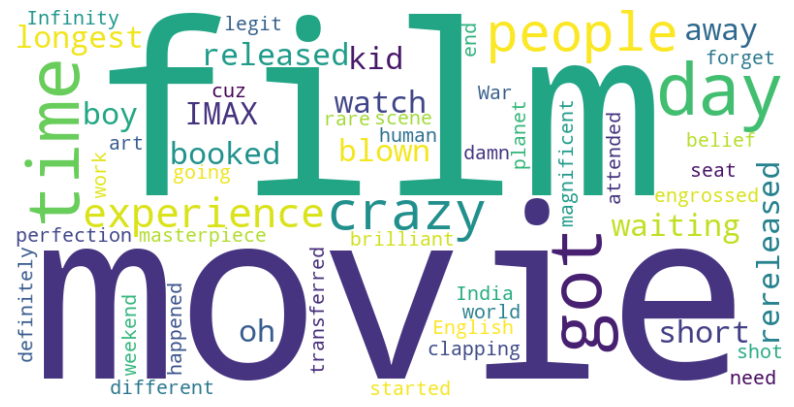

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(cloud(df['Tokens lemmatisés'][0]), interpolation='bilinear')
plt.axis("off")
plt.show()

Par exemple, pour le premier commentaire de la bdd, on peut dès à présent avoir une idée sur son avis vis à vis du film grâce à ce nuage de mots, de par la présence de mots tels que 'masterpiece, 'magnificent', 'perfection'... qui sont assez représentés. Néanmoins, comme nous avons utilisé nltk, le lemmatiseur ne reconnait pas les entités nommés telles que 'IMAX', 'India'... .

## **2.** NLP et analyse de sentiments

In [16]:
#Convertir les commentaires en string.
def string_function(column):
    return column.str.lower()

df['Commentaire'] =  string_function(df["Commentaire"])

Nous allons comparer les différents algorithmes proposés, notamment ceux des modules TextBlob, nltk et scapy.

On va dans un premier temps utiliser le module TextBlob

In [17]:
def analyze_sentiment_blob(tokens):
    text = ' '.join(tokens)
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [18]:
# Appliquez la fonction à la colonne 'tokens_lemmatized' du DataFrame
df['sentiment_polarity_blob'] = df['Tokens lemmatisés'].apply(analyze_sentiment_blob)

On essaye maintenant avec la fonction SentimentIntensityAnalyzer de nltk

In [19]:
def analyze_sentiment_nltk(tokens):
    text = ' '.join(tokens)
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

In [20]:
%%time
df['sentiment_polarity_nltk'] = df["Tokens lemmatisés"].apply(analyze_sentiment_nltk)

CPU times: total: 3min 44s
Wall time: 3min 55s


On essaye enfin de faire de l'analyse de sentiment avec le module scapy.

La fonction ci-dessus ne fonctionne pas bien puisqu'elle retourne que des 0. Je la laisse au cas où on trouve le problème.

Les notes et les années sont sous forme de string. Nous changeons cela pour pourvoir faire des statistiques avec.

In [ ]:
df.dtypes

Film                        object
Commentaire                 object
Annee                       object
Note imdb                   object
Budget                      object
Box office                  object
duree                       object
Tokens                      object
Tokens lemmatisés           object
sentiment_polarity_blob    float64
dtype: object

In [21]:
#change le type de la colonne 'Note imdb' en float
df['Note imdb'] = df['Note imdb'].str.replace(',', '.').astype(float)
df['Annee'] = df['Annee'].astype(float)
df["Budget"] = df["Budget"].astype(float)
df['Box office'] = df["Box office"].astype(float)

On groupe les observations selon le film.

In [ ]:
grouped = df.groupby('Film')
df_grouped = grouped[["sentiment_polarity_nltk", "sentiment_polarity_blob",  'Note imdb', 'Annee', "Budget", "Box office"]].mean()

KeyError: "Columns not found: 'sentiment_polarity_nltk'"

Il peut être interessant de regarder aussi la variance des scores

In [ ]:
var_by_group = grouped[["sentiment_polarity_nltk", "sentiment_polarity_blob"]].var()

In [ ]:
correlation = mean_by_group['sentiment_polarity_nltk'].corr(mean_by_group['Note imdb'])
print(f"La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film évalué avec la library nltk est de {correlation}")

La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film est de 0.2978600852174349


In [ ]:
correlation = mean_by_group['sentiment_polarity_blob'].corr(mean_by_group['Note imdb'])
print(f"La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de {correlation}")

La correlation entre les notes sur imbd et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de 0.519272018770084


In [ ]:
correlation = mean_by_group['sentiment_polarity_nltk'].corr(mean_by_group['sentiment_polarity_blob'])
print(f"La correlation entre la moyenne des scores de la polarité des sentiments par film évalué avec la library nltk et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de {correlation}")

La correlation entre la moyenne des scores de la polarité des sentiments par film évalué avec la library nltk et la moyenne des scores de la polarité des sentiments par film évalué avec la library textblob est de 0.7549503705343742


Il y a une relation positive non négligeable entre les notes et le score des commentaires. Il y a également une forte corrélation entre les scores évalués par textblob et ceux évalués par nltk.

In [22]:
df.to_csv('Dataframe.csv', index=False)

# Un peu de Visualisation

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid", palette="deep", color_codes=True)

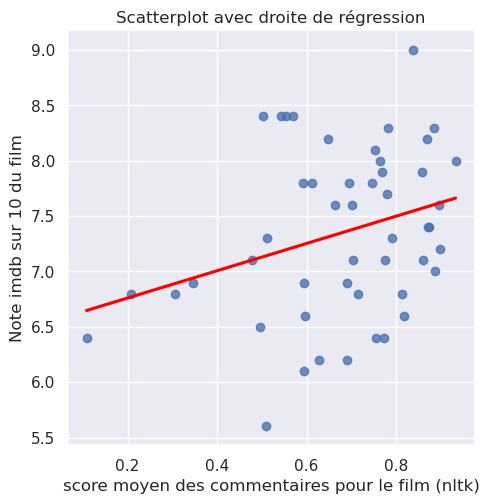

In [ ]:
# Affichez le nuage de points
sns.lmplot(x='sentiment_polarity_nltk', y='Note imdb', data=mean_by_group, line_kws={'color': 'red'}, ci=None)

# Ajout de titres et de labels
plt.title('Scatterplot avec droite de régression')
plt.xlabel('score moyen des commentaires pour le film (nltk)')
plt.ylabel('Note imdb sur 10 du film')

# Affichage du graphique
plt.show()

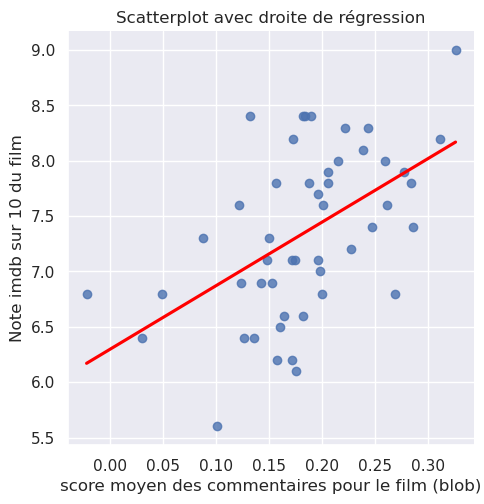

In [ ]:
# Affichez le nuage de points
sns.lmplot(x='sentiment_polarity_blob', y='Note imdb', data=mean_by_group, line_kws={'color': 'red'}, ci=None)

# Ajout de titres et de labels
plt.title('Scatterplot avec droite de régression')
plt.xlabel('score moyen des commentaires pour le film (blob)')
plt.ylabel('Note imdb sur 10 du film')

# Affichage du graphique
plt.show()

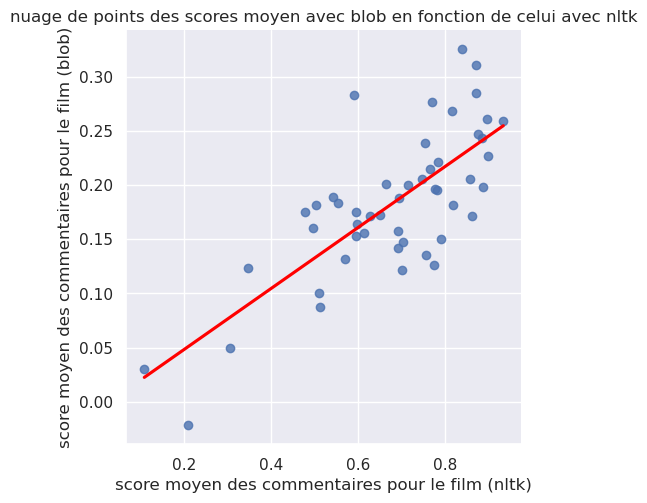

In [ ]:
# Affichez le nuage de points
sns.lmplot(x='sentiment_polarity_nltk', y='sentiment_polarity_blob', data=mean_by_group, line_kws={'color': 'red'}, ci=None)

# Ajout de titres et de labels
plt.title('nuage de points des scores moyen avec blob en fonction de celui avec nltk')
plt.xlabel('score moyen des commentaires pour le film (nltk)')
plt.ylabel('score moyen des commentaires pour le film (blob)')

# Affichage du graphique
plt.show()

<h2>Modélisation</h2>

Dans cette partie, nous allons créer un modèle qui prédit la note d'un film à partir des variables du Dataframe que nous avons depuis le départ et les nouvelles variables qu'on vient d'ajouter avec l'analyse de sentiment.

In [11]:
df = pd.read_csv('Dataframe.csv')

In [12]:
# Import d'éléments nécessaires de Scikit-learn

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

<h3>Preprocessing</h3>

Il faut d'abord commencer par préparer notre jeu de données pour qu'il soit possible de réaliser un modèle de prédiction. Pour cela, on encode les variables catégorielles et on normalise les variables quantitatives.

Commençons maintenant par l'analyse des données manquantes. Pour cela nous allons visualiser un heatmap des valeurs manquantes de tout le dataframe.

<Axes: >

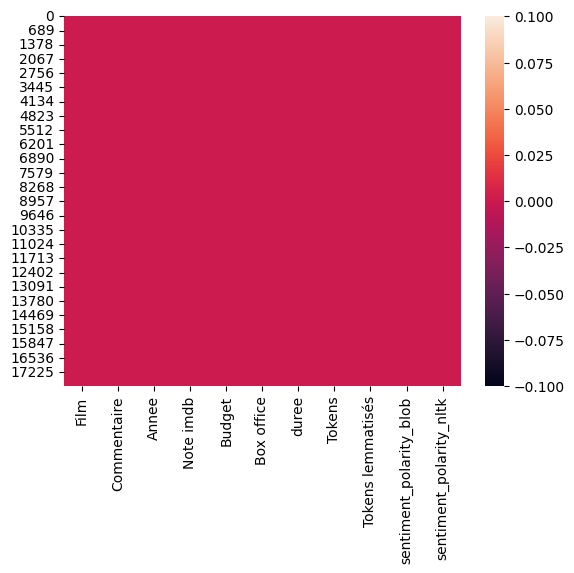

In [13]:
sns.heatmap(df.isna())

Comme nous avons extrait toutes les données nous-mêmes pour assembler ce je de données, on se doute bien qu'il n'y aura pas de valeurs manquantes.


In [14]:
df.dtypes

Film                        object
Commentaire                 object
Annee                      float64
Note imdb                  float64
Budget                     float64
Box office                 float64
duree                       object
Tokens                      object
Tokens lemmatisés           object
sentiment_polarity_blob    float64
sentiment_polarity_nltk    float64
dtype: object

In [22]:
df2 = df.copy()

In [16]:
def convert_min(duree):
    if 'h' in duree and 'm' in duree:
        # Séparation de la durée en heures et minutes
        hours, minutes = map(int, duree.replace('h', '').replace('m', '').split())
    elif 'h' in duree:
        # Si la chaîne contient "h" mais pas "m"
        hours = int(duree.split('h')[0])
        minutes = 0
    elif 'm' in duree:
        # Si la chaîne contient "m" mais pas "h"
        hours = 0
        minutes = int(duree.split('m')[0])
    else:
        # Si la chaîne ne contient ni "h" ni "m"
        hours = int(duree)
        minutes = 0
    return hours*60 + minutes
    

In [17]:
# Dans le cas où o considère la durée comme une variable quantitative
df2['duree'] = df2['duree'].apply(convert_min)

In [20]:
def longueur(duree):
    if duree < '1h 45m':
        return 'court'
    elif '1h 45m' <= duree <= '2h 20m':
        return 'moyen'
    else:
        return 'long'

In [23]:
# Dans le cas où on veuille considére la durée comme une variable catégorielle
df2['duree'] = df2['duree'].apply(longueur)

Commençons par encoder la variable durée (encodeage one-hot)

In [24]:
encoded_col = pd.get_dummies(df2['duree'], prefix = 'duree')
df2 = pd.concat([df2,encoded_col], axis=1)
df2.head()

,Film,Commentaire,Annee,Note imdb,Budget,Box office,duree,Tokens,Tokens lemmatisés,sentiment_polarity_blob,sentiment_polarity_nltk,duree_court,duree_long,duree_moyen
0,Avatar (2009),i was waiting for this day for the longest time. i was a kid back in 2009 when this movie releas...,2009.0,7.9,237000000.0,2.923706e+09,long,"['waiting', 'day', 'longest', 'time', 'kid', '2009', 'movie', 'released', 'got', 'watch', 'rerel...","['waiting', 'day', 'longest', 'time', 'kid', '2009', 'movie', 'released', 'got', 'watch', 'rerel...",0.100000,0.8750,False,True,False
1,Avatar (2009),"forgive me, i'm going to jump from professional to fan boy for a while here. i haven't had the j...",2009.0,7.9,237000000.0,2.923706e+09,long,"['Forgive', 'going', 'jump', 'professional', 'fan', 'boy', 'jitters', 'film', 'way', 'Avatar', '...","['Forgive', 'going', 'jump', 'professional', 'fan', 'boy', 'jitter', 'film', 'way', 'Avatar', 'J...",0.226744,0.9989,False,True,False
2,Avatar (2009),"i did see avatar for the first time a while ago, and didn't know what to make of it. to me it fe...",2009.0,7.9,237000000.0,2.923706e+09,long,"['Avatar', 'time', 'ago', 'know', 'felt', 'like', 'visual', 'feast', 'little', 'watching', 'foun...","['Avatar', 'time', 'ago', 'know', 'felt', 'like', 'visual', 'feast', 'little', 'watching', 'foun...",0.208824,0.9964,False,True,False
3,Avatar (2009),"although i was not too bothered about seeing avatar as a film, i felt it was a bit foolish to le...",2009.0,7.9,237000000.0,2.923706e+09,long,"['bothered', 'seeing', 'Avatar', 'film', 'felt', 'bit', 'foolish', 'let', 'milestone', 'cinema',...","['bothered', 'seeing', 'Avatar', 'film', 'felt', 'bit', 'foolish', 'let', 'milestone', 'cinema',...",0.170213,0.9929,False,True,False
4,Avatar (2009),hatts of to james cameron for thinking and creating a vision like this. it takes a lotseof hardw...,2009.0,7.9,237000000.0,2.923706e+09,long,"['Hatts', 'JAMES', 'CAMERON', 'thinking', 'creating', 'vision', 'like', 'takes', 'lotseof', 'har...","['Hatts', 'JAMES', 'CAMERON', 'thinking', 'creating', 'vision', 'like', 'take', 'lotseof', 'hard...",0.174040,0.9432,False,True,False


Avant de procéder à la suite, nous allons d'abord supprimer des colonnes dont nous n'avons pas besoin.

In [25]:
df2.drop(['Commentaire', 'Tokens', 'Tokens lemmatisés', 'duree'], axis=1, inplace=True)
df2.head()

,Film,Annee,Note imdb,Budget,Box office,sentiment_polarity_blob,sentiment_polarity_nltk,duree_court,duree_long,duree_moyen
0,Avatar (2009),2009.0,7.9,237000000.0,2.923706e+09,0.100000,0.8750,False,True,False
1,Avatar (2009),2009.0,7.9,237000000.0,2.923706e+09,0.226744,0.9989,False,True,False
2,Avatar (2009),2009.0,7.9,237000000.0,2.923706e+09,0.208824,0.9964,False,True,False
3,Avatar (2009),2009.0,7.9,237000000.0,2.923706e+09,0.170213,0.9929,False,True,False
4,Avatar (2009),2009.0,7.9,237000000.0,2.923706e+09,0.174040,0.9432,False,True,False


Divisons le dataframe en un test set et un train set pour pouvoir faire la régression.

In [26]:
columns = ['Annee', 'Budget', 'Box office', 'duree_court', 'duree_moyen', 'sentiment_polarity_blob', 'sentiment_polarity_nltk']
X_train, X_test, y_train, y_test = train_test_split(df2[columns], df2['Note imdb'], test_size=0.2)

Maintenant, procédons à la standardisation des variables quantitatives. Pour cela, nous allons entraîner le Standardscaler de sklearn avec le train set et le transformer, puis nous allons tnansformer le est set avec ce même scaler.

In [27]:
quantitative_data = X_train.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
standardized_quantitative = scaler.fit_transform(quantitative_data)

cols = list(quantitative_data.columns)
X_train[cols] = standardized_quantitative
X_test[cols] = scaler.transform(X_test[cols])


Maintenant commençons par faire une première régression linéaire avec toutes les variables que nous avons dans ce jeu de données.

In [28]:
modele = LinearRegression()
modele.fit(X_train, y_train)

predictions = modele.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

mse, r2

(0.5532008975932647, 0.12287870278228119)

Désormais, nous allons regrouper les observations par film. Mais avant, nous allons d'abord commencer par calculer les moyennes des deux scores d'analyse de sentoments pour chaque film.

In [29]:
mean_blob = df2.groupby('Film')['sentiment_polarity_blob'].mean()
mean_nltk = df2.groupby('Film')['sentiment_polarity_nltk'].mean()

In [30]:
df_films = df2[['Film', 'Annee', 'Note imdb', 'Budget', 'Box office', 'duree_court', 'duree_moyen', 'duree_long']]
df_films = df_films.drop_duplicates()
df_films.set_index('Film', inplace=True)
df_films.head()

,Annee,Note imdb,Budget,Box office,duree_court,duree_moyen,duree_long
Film,,,,,,,
Avatar (2009),2009.0,7.9,237000000.0,2.923706e+09,False,False,True
Avengers: Endgame (2019),2019.0,8.4,356000000.0,2.799439e+09,False,False,True
Avatar : La Voie de l'eau (2022),2022.0,7.6,350000000.0,2.320250e+09,False,False,True
Titanic (1997),1997.0,7.9,200000000.0,2.264743e+09,False,False,True
Star Wars : Épisode VII - Le Réveil de la Force (2015),2015.0,7.8,245000000.0,2.071310e+09,False,True,False


In [31]:
df_films = pd.concat([df_films, mean_blob, mean_nltk], axis=1 )
df_films.head()

,Annee,Note imdb,Budget,Box office,duree_court,duree_moyen,duree_long,sentiment_polarity_blob,sentiment_polarity_nltk
Film,,,,,,,,,
Avatar (2009),2009.0,7.9,237000000.0,2.923706e+09,False,False,True,0.213078,0.844516
Avengers: Endgame (2019),2019.0,8.4,356000000.0,2.799439e+09,False,False,True,0.203876,0.560758
Avatar : La Voie de l'eau (2022),2022.0,7.6,350000000.0,2.320250e+09,False,False,True,0.134227,0.692707
Titanic (1997),1997.0,7.9,200000000.0,2.264743e+09,False,False,True,0.262590,0.731694
Star Wars : Épisode VII - Le Réveil de la Force (2015),2015.0,7.8,245000000.0,2.071310e+09,False,True,False,0.172762,0.611374


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


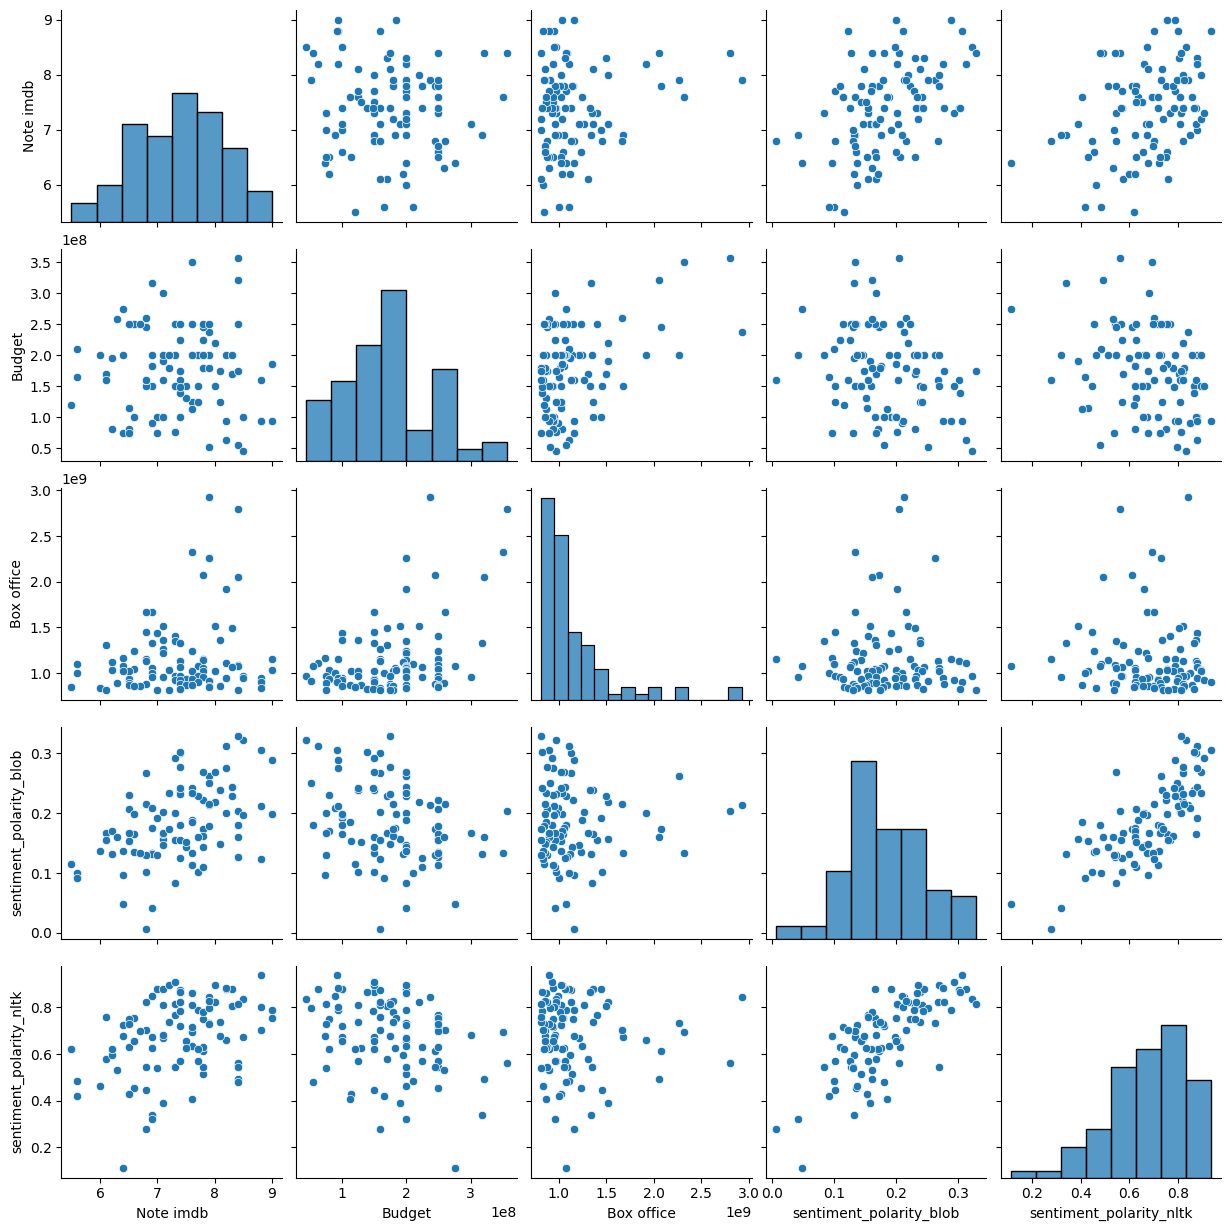

In [38]:
sns.pairplot(df_films.drop(['Annee', 'duree_court', 'duree_moyen', 'duree_long'], axis = 1))

In [39]:
df_films.drop(['Annee', 'duree_court', 'duree_moyen', 'duree_long'], axis = 1).corr()

,Note imdb,Budget,Box office,sentiment_polarity_blob,sentiment_polarity_nltk
Note imdb,1.000000,-0.055634,0.174280,0.473369,0.370997
Budget,-0.055634,1.000000,0.420877,-0.293974,-0.309377
Box office,0.174280,0.420877,1.000000,-0.005480,-0.050392
sentiment_polarity_blob,0.473369,-0.293974,-0.005480,1.000000,0.741763
sentiment_polarity_nltk,0.370997,-0.309377,-0.050392,0.741763,1.000000


In [63]:
columns = ['Budget', 'Box office', 'duree_court', 'duree_moyen', 'sentiment_polarity_blob']
X_train, X_test, y_train, y_test = train_test_split(df_films[columns], df_films['Note imdb'], test_size=0.2)

In [67]:
quantitative_data = X_train.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
standardized_quantitative = scaler.fit_transform(quantitative_data)

cols = list(quantitative_data.columns)
X_train[cols] = standardized_quantitative
X_test[cols] = scaler.transform(X_test[cols])

In [77]:
modele = LinearRegression()
modele.fit(X_train, y_train)

predictions = modele.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
coefficients = modele.coef_
intercept = modele.intercept_


mse, r2, intercept, coefficients

(0.4501943566077634,
 0.4126909412568569,
 7.528089123752865,
 array([ 0.00064414,  0.07138682, -0.47100683, -0.35169491,  0.37170828]))

In [59]:
coeff_df = pd.DataFrame(coefficients, X_train.columns, columns = ['Coeffcients'])
coeff_df

,Coeffcients
Budget,-0.005880
Box office,0.100882
duree_court,-0.553514
duree_moyen,-0.508467
sentiment_polarity_blob,0.420220
sentiment_polarity_nltk,0.042216


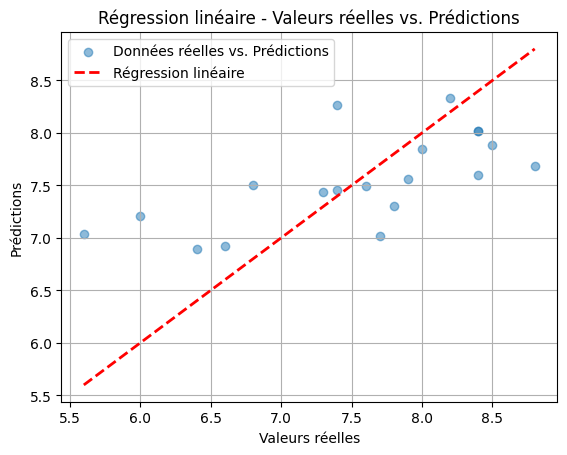

In [78]:
# Tracer les points de données
plt.scatter(y_test, predictions, alpha=0.5, label='Données réelles vs. Prédictions')

# Tracer la droite de régression (y = mx + c)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Régression linéaire', linewidth=2)

plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Régression linéaire - Valeurs réelles vs. Prédictions')
plt.legend()
plt.grid(True)
plt.show()

A présent faisons une régression sur l'ensemble des données sans essayer de prédire avec un modèle.


In [73]:
X, y = df_films[columns], df_films['Note imdb']
quantitative_data = X.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
standardized_quantitative = scaler.fit_transform(quantitative_data)

cols = list(quantitative_data.columns)
X[cols] = standardized_quantitative

C:\Users\USER\AppData\Local\Temp\ipykernel_10404\2121576112.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cols] = standardized_quantitative


In [74]:
modele_2 = LinearRegression()
modele_2.fit(X, y)

predictions = modele_2.predict(X)
mse_2 = mean_squared_error(y, predictions, squared=False)
r2_2 = r2_score(y, predictions)
coefficients_2 = modele_2.coef_
intercept_2 = modele_2.intercept_


mse_2, r2_2, intercept_2, coefficients_2

(0.647274281178208,
 0.3188540673391218,
 7.5700598226272655,
 array([-0.03853274,  0.12224493, -0.46997798, -0.39089778,  0.41228917]))

In [75]:
coeff_df_2 = pd.DataFrame(coefficients_2, X.columns, columns = ['Coeffcients'])
coeff_df_2

,Coeffcients
Budget,-0.038533
Box office,0.122245
duree_court,-0.469978
duree_moyen,-0.390898
sentiment_polarity_blob,0.412289


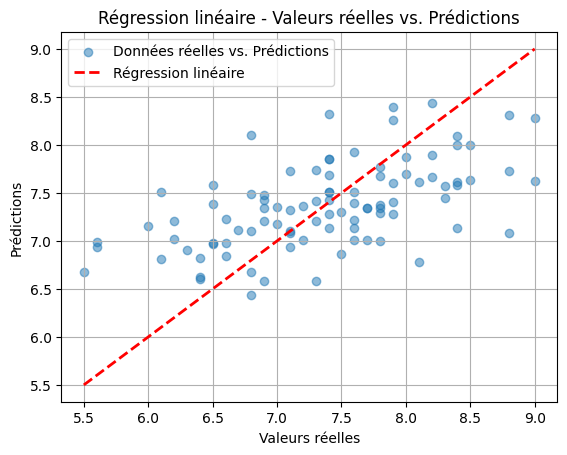

In [76]:
# Tracer les points de données
plt.scatter(y, predictions, alpha=0.5, label='Données réelles vs. Prédictions')

# Tracer la droite de régression (y = mx + c)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Régression linéaire', linewidth=2)

plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Régression linéaire - Valeurs réelles vs. Prédictions')
plt.legend()
plt.grid(True)
plt.show()